<a href="https://colab.research.google.com/github/johannnamr/Discrepancy-based-inference-using-QMC/blob/main/Inference/G-and-k-distribution/gandk_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# G-and k distribution

Notebook for the check of gradients

### Mount Drive

In [ ]:
# mount my drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


The following path has to be adjusted if necessary:

In [ ]:
%run "/content/drive/My Drive/Colab Notebooks/Utils.ipynb"
%run "/content/drive/My Drive/Colab Notebooks/Plot_fcts.ipynb"

     |████████████████████████████████| 1.5MB 5.9MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 4.0 MB 6.3 MB/s 
     |████████████████████████████████| 430 kB 5.0 MB/s 


### Imports

In [ ]:
import numpy as np
import qmcpy

from copy import deepcopy

import jax.numpy as jnp
from jax import jacfwd
from jax import ops
from jax import lax

### Sampling

In [ ]:
np.random.seed(111)

Set parameters:

In [ ]:
m = 1500                                  # number of simulated samples
n = 1000                                  # number of true samples
theta = np.array([3,1,1,-np.log(2)])      # true theta
d = 1                                     # dimensions of data
p = len(theta)                            # dimensions of parameter space
l = 1.5                                   # lengthscale (l=-1 for median heuristic)
c = 0
b = 0
nu = 0
kernel = 'gaussian'                       # 'gaussian', 'imq' or 'matern'
stat_type = 'v'                           # 'u' for U-statistic, 'v' for v-statistic

Define QMC sequence:

In [ ]:
qmc = qmcpy.Halton(d+1)

Sample from the g-and-k distribution:

In [ ]:
y,_ = sample_gandk('MC',m,d,theta)
x,z = sample_gandk('MC',n,d,theta)

Plot samples and generator:

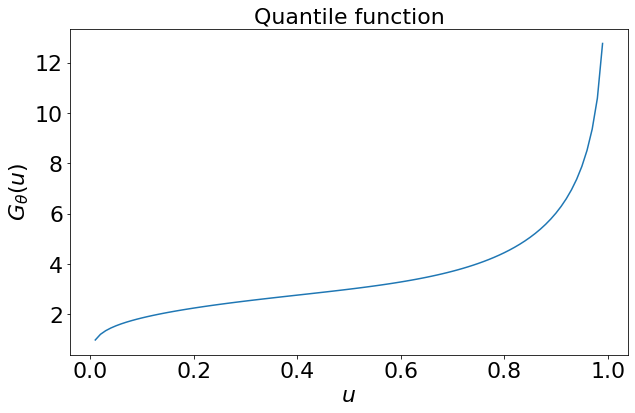

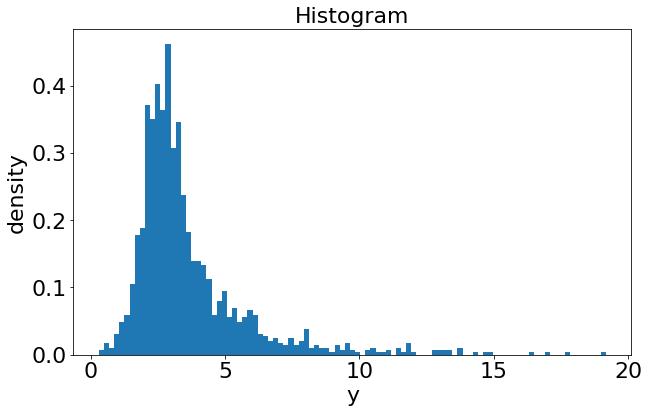

In [ ]:
plot_gandk(y,(10,6),theta)

### Check generator gradient

In [ ]:
print('gradient of the generator:')
grad_gen_gandk(z,theta[:4])[:,:,0]

gradient of the generator:


array([[1.   , 1.066, 0.207, 0.417]])

In [ ]:
# check gradient
def gen_test(z, theta):
    a = theta[0]
    b = theta[1]
    g = theta[2]
    k = theta[3]
    x = a+b*(1+0.8*((1-jnp.exp(-g*z))/(1+jnp.exp(-g*z))))*((1+z**2)**(k))*z
    return x
grad_test = jacfwd(gen_test,1)
theta_test = deepcopy(theta)
theta_test[3] = np.exp(theta[3])

In [ ]:
print('check gradient using autodifferentiation:')
print(grad_gen_gandk(z,theta)[:,:,0])
print(grad_test(z,theta_test)[0])

check gradient using autodifferatiation:
[[1.    1.066 0.207 0.417]]
[[1.    1.066 0.207 0.417]]


### Check kernel

In [ ]:
kxx = k(x,x,kernel,l,c,b,nu)
kxy = k(x,y,kernel,l,c,b,nu)
kyy = k(y,y,kernel,l,c,b,nu)
k1xx = kxx[1]
k1xy = kxy[1]
k21xx = kxx[2]

In [ ]:
print('kernel:')
print(kxy[0][1,1])
print('\nderivative w.r.t. the first element:')
print(kxy[1][:,1,1])
print('\nderivative w.r.t. the second and first element:')
print(kxy[2][:,:,1,1])

kernel:
0.9753028053358747

derivative w.r.t. the first element:
[-0.145]

derivative w.r.t. the second and first element:
[[0.412]]


In [ ]:
#check derivatives using finite differences
print('check first derivative w.r.t. the first element:')
print((k(x+0.00000001,y,kernel,l,c,b,nu)[0][1,1]-kxy[0][1,1])/0.00000001)
print(np.sum(kxy[1][:,1,1]))
print('\ncheck second derivative w.r.t. the second and first element:')
print((-k(x+0.00000001,y,kernel,l,c,b,nu)[1][:,1,1]+kxy[1][:,1,1])/0.00000001)
print(np.sum(kxy[2][:,:,1,1],axis=0))

check first derivative w.r.t. the first element:
-0.14541073900531387
-0.14541074453420008

check second derivative w.r.t. the second and first element:
[0.412]
[0.412]


### Check the MMD$^2$ gradient $\hat{J}$

In [ ]:
print('MMD^2 approximation:')
MMD_approx(n,m,kxx[0],kxy[0],kyy[0],stat_type)

MMD^2 approximation:


0.0011101088298280937

In [ ]:
grad_g = grad_gen_gandk(z, theta)
print('gradient of the MMD^2 approximation:')
grad_MMD(p,n,m,grad_g,k1xx,k1xy,stat_type)

gradient of the MMD^2 approximation:


array([ 0.015,  0.007, -0.   ,  0.004])

In [ ]:
# check gradient using finite differences
par = 1
theta_check = deepcopy(theta)
theta_check[par] = theta_check[par] + 0.00000001
x_check = gen_gandk(z,theta_check)
print('check gradient of the MMD^2 approximation:')
print((MMD_approx(n,m,k(x_check,x_check,kernel,l,c,b,nu)[0],k(x_check,y,kernel,l,c,b,nu)[0],kyy[0],stat_type)-MMD_approx(n,m,kxx[0],kxy[0],kyy[0],stat_type))/0.00000001)
print(grad_MMD(p,n,m,grad_g,k1xx,k1xy,stat_type)[par])

check gradient of the MMD^2 approximation:
0.0072234662695791485
0.007223462111478729


### Test information metric $g_U(\theta)$

In [ ]:
# test function
print('approximation of information metric g:')
g_approx(p,n,grad_g,k21xx)

approximation of information metric g:


array([[ 0.115, -0.042,  0.013, -0.041],
       [-0.042, -0.048, -0.031, -0.078],
       [ 0.013, -0.031,  0.003, -0.031],
       [-0.041, -0.078, -0.031, -0.118]])

## Sampling from $d=2$ model:

In [ ]:
from matplotlib.lines import Line2D

In [ ]:
np.random.seed(133)

In [ ]:
d = 2
m = 2**20
n = 2**6
theta = np.array([3,1,1,-np.log(2)])

In [ ]:
qmc = qmcpy.Halton(d,seed=7)

In [ ]:
SMALL_SIZE = 20
MEDIUM_SIZE = 32
BIGGER_SIZE = 32

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

In [ ]:
y,_ = sample_gandk_inv('QMC',m,d,theta)
x_mc,_ = sample_gandk_inv('MC',n,d,theta)
x_rqmc,_ = sample_gandk_inv('RQMC',n,d,theta)

In [ ]:
rng_min = np.min(y)
rng_max = np.max(y)
num_bins = 100

In [ ]:
y1 = np.arange(rng_min, rng_max, (rng_max-rng_min)/num_bins)
y2 = np.arange(rng_min, rng_max, (rng_max-rng_min)/num_bins)

Y1, Y2 = np.meshgrid(y1, y2)

In [ ]:
hist,_,_ =np.histogram2d(y[:,0],y[:,1], bins=num_bins, density=True)

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,sharey=True, sharex=True, figsize=(15,7))
cmap = plt.get_cmap("tab10")
cmap2 = plt.get_cmap('Greys')

ax1.contour(Y1,Y2,hist,levels=(0.00025,0.002,0.005,0.01,0.02,0.04,0.06,0.1,0.17),colors='darkslategrey')
ax1.scatter(x_mc[:,0],x_mc[:,1],color=cmap(0),s=100)
ax1.set_ylim((-1,22))
ax1.set_xlim((-1,22))
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax1.set_xticks([0,10,20])
ax1.set_xticklabels([0,10,20])

ax2.contour(Y1,Y2,hist,levels=(0.00025,0.002,0.005,0.01,0.02,0.04,0.06,0.1,0.17),colors='darkslategrey')
ax2.scatter(x_rqmc[:,0],x_rqmc[:,1],color=cmap(2),s=100)
ax2.set_xlabel(r'$x_1$')


dots = [Line2D([0], [0], marker='o', color='w', label='Scatter',markerfacecolor=cmap(0), markersize=15),Line2D([0], [0], marker='o', color='w', label='Scatter',markerfacecolor=cmap(2), markersize=15)]
ax2.legend(handles=dots, labels=['MC','QMC'])

plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig('gandk_d=2_scatter.png',bbox_inches = 'tight', pad_inches = .1)
plt.show()

Sampling from $d=1$ model:

In [ ]:
from scipy.spatial import distance
from scipy.linalg import norm
from scipy.stats import entropy

In [ ]:
np.random.seed(2)

In [ ]:
d = 1
n = 2**11
m = 2**20
theta = np.array([3,1,1,-np.log(2)])

In [ ]:
qmc = qmcpy.Halton(d,seed=7)

In [ ]:
y = sample_gandk_inv('QMC',m,d,theta)
x_mc = sample_gandk_inv('MC',n,d,theta)
x_rqmc = sample_gandk_inv('RQMC',n,d,theta)

In [ ]:
rng_min = -1
rng_max = 25
num_bins =20

In [ ]:
y_hist,_ = np.histogram(np.squeeze(y[0]),density=True, bins=num_bins,range=(rng_min,rng_max))
x_mc_hist,_ = np.histogram(np.squeeze(x_mc[0]),density=True, bins=num_bins,range=(rng_min,rng_max))
x_rqmc_hist,_ = np.histogram(np.squeeze(x_rqmc[0]),density=True, bins=num_bins,range=(rng_min,rng_max))

In [ ]:
def hellinger(p, q):
    return norm(np.sqrt(p) - np.sqrt(q)) / np.sqrt(2)

In [ ]:
y_hist[y_hist==0] = 1e-16
x_mc_hist[x_mc_hist==0] = 1e-16
x_rqmc_hist[x_rqmc_hist==0] = 1e-16

In [ ]:
dist_l2_mc = np.squeeze(distance.cdist(np.expand_dims(y_hist,0),np.expand_dims(x_mc_hist,0),'euclidean'))
dist_l2_rqmc = np.squeeze(distance.cdist(np.expand_dims(y_hist,0),np.expand_dims(x_rqmc_hist,0),'euclidean'))
dist_kl_mc = entropy(pk=y_hist,qk=x_mc_hist)
dist_kl_rqmc = entropy(pk=y_hist,qk=x_rqmc_hist)
dist_h_mc = hellinger(p=y_hist,q=x_mc_hist)
dist_h_rqmc = hellinger(p=y_hist,q=x_rqmc_hist)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83


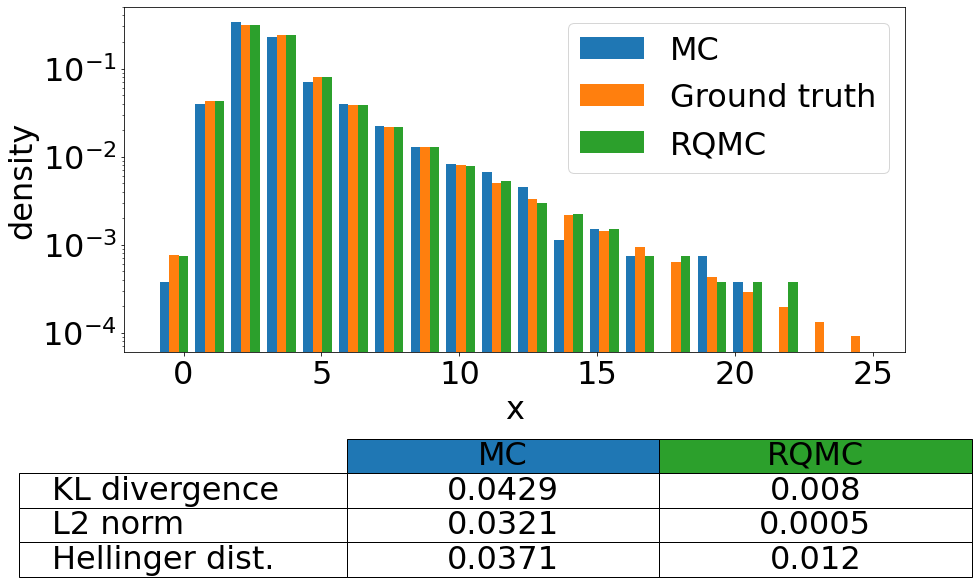

In [ ]:
plt.figure(figsize=(14,10))
cmap = plt.get_cmap("tab10")
plt.hist([np.squeeze(x_mc[0]),np.squeeze(y[0]),np.squeeze(x_rqmc[0])], bins=num_bins, range=(rng_min, rng_max),density=True,color = [cmap(0),cmap(1),cmap(2)], label=['MC','Ground truth','RQMC'])
plt.yscale('log', nonposy='clip')
plt.ylabel('density')
plt.xlabel('x')
plt.legend(loc='upper right')
plt.table(cellText=((str(np.round(dist_kl_mc,4)),str(np.round(dist_kl_rqmc,4))),(str(np.round(dist_l2_mc,4)),str(np.round(dist_l2_rqmc,4))),(str(np.round(dist_h_mc,4)),str(np.round(dist_h_rqmc,4)))), rowLabels=('KL divergence','L2 norm','Hellinger dist.     '), colLabels=('MC','RQMC'),loc='bottom', bbox=[0.285,-0.65,0.8,0.4],cellLoc='center',colColours=(cmap(0),cmap(2)))
plt.subplots_adjust(bottom=0.4)
plt.savefig('gandk_d=1_hist.png',bbox_inches = 'tight', pad_inches = .1)
plt.show()